# Prompt Evaluation with Promptify

This is a practical example on how prompt evaluation can help development and prompt engineering.
https://github.com/promptslab/Promptify

In [55]:
from datasets import load_dataset

dataset = load_dataset("squad")

Found cached dataset squad (C:/Users/AntonioVelasco/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)
100%|██████████| 2/2 [00:00<00:00, 92.72it/s]


In [56]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [57]:
import pandas as pd

df = pd.DataFrame(dataset['train'])

In [58]:
df.head()

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'..."
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,{'text': ['a Marian place of prayer and reflec...
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,{'text': ['a golden statue of the Virgin Mary'...


Let's make a single call as a test.

In [59]:
import json
import os
import openai

with open('../.vscode/settings.json') as f:
    data = json.load(f)

os.environ['API_KEY'] = data['API_KEY']
openai.api_key = os.environ['API_KEY']


Given the context:

In [60]:
context = df.iloc[0,2]
context

'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'

and the query:

In [61]:
query = df.iloc[0,3]
query

'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'

In [62]:
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "system", "content": context},
      {"role": "user", "content": query},
    ]
  )

answer = response.get("choices")[0]["message"]["content"]
answer

'The Virgin Mary allegedly appeared to Saint Bernadette Soubirous in 1858 in Lourdes, France.'

Which is technically correct but too verbose if we compare it with the desired output: 

In [63]:
exact_answer = df.iloc[0,4]['text']
exact_answer

['Saint Bernadette Soubirous']

### Tests types

In [87]:
from difflib import SequenceMatcher
from promptimize import evals

def sequence_matcher(a, b):
    return SequenceMatcher(None, a, b).ratio()

def jaccard_similarity(a, b):
    intersection = len(set(a).intersection(set(b)))
    union = len(set(a).union(set(b)))
    return intersection / union

In [89]:
answer

'The Virgin Mary allegedly appeared to Saint Bernadette Soubirous in 1858 in Lourdes, France.'

In [90]:
exact_answer

['Saint Bernadette Soubirous']

In [91]:
sequence_matcher(answer,exact_answer[0])

0.4406779661016949

SequenceMatcher is a class in the difflib module of Python that provides a way to compare pairs of sequences of any type, as long as the sequence elements are hashable.

The idea is to find the longest contiguous matching subsequence that contains no “junk” elements (these “junk” elements are ones that are uninteresting in some sense, such as blank lines or whitespace). The same idea is then applied recursively to the pieces of the sequences to the left and to the right of the matching subsequence.

In [92]:
jaccard_similarity(answer,exact_answer[0])

0.4666666666666667

The Jaccard similarity coefficient, also known as the Jaccard index, is a statistic used for gauging the similarity and diversity of sample sets. It measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets. In other words, it is calculated as:

```
Jaccard Similarity = (number of observations in both sets) / (number in either set) or J(A, B) = |A∩B| / |A∪B|
```

The Jaccard similarity ranges from 0 to 1. The closer to 1, the more similar the two sets of data are. If two datasets share the exact same members, their Jaccard Similarity Index will be 1. Conversely, if they have no members in common then their similarity will be 0.

In [93]:
evals.percentage_of_words(answer,exact_answer[0])

1.0

This one is way simpler, percentage of desired answer words present in the model output

In [94]:
evals.any_word(answer, ["Saint Bernadette", "Saint Bernadette Soubirous", "Bernadette Soubirous"])

1

Wether any of the words in the list is present on the LLM output. 

# Let's create a proper test environment

let's select some random entries

In [95]:
import numpy as np

# set the seed for reproducibility
np.random.seed(42)

# randomly select 20 rows from the dataframe
corpus = df.sample(n=20)

# we are not interested in the placement of the answer, so making it the straight entry
corpus['answers'] = corpus['answers'].apply(lambda x: x['text'][0])

corpus.head(3)

,id,title,context,question,answers
9983,56de4d9ecffd8e1900b4b7e2,Institute_of_technology,The world's first institution of technology or...,What year was the Banská Akadémia founded?,1735
43267,572674a05951b619008f7319,Film_speed,The standard specifies how speed ratings shoul...,What is another speed that can also be reporte...,SOS-based speed
81021,5730bb058ab72b1400f9c72c,Sumer,The most impressive and famous of Sumerian bui...,Where were the use of advanced materials and t...,Sumerian temples and palaces


# Performance study

From 20 labeled documents the text will be extracted, processed by the model and meassured by 3 metrics

In [96]:
VERSION = "ver001"

corpus[f'{VERSION}_llm_answer'] = corpus.apply(lambda row:
    openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
        {"role": "system", "content": row['context']},
        {"role": "user", "content": row ['question']},
        ]
    ).get("choices")[0]["message"]["content"],
    axis = 1
    )

In [97]:
corpus.head(3)

,id,title,context,question,answers,ver001_llm_answer
9983,56de4d9ecffd8e1900b4b7e2,Institute_of_technology,The world's first institution of technology or...,What year was the Banská Akadémia founded?,1735,The Banská Akadémia was founded in 1735.
43267,572674a05951b619008f7319,Film_speed,The standard specifies how speed ratings shoul...,What is another speed that can also be reporte...,SOS-based speed,Another speed that can be reported by the came...
81021,5730bb058ab72b1400f9c72c,Sumer,The most impressive and famous of Sumerian bui...,Where were the use of advanced materials and t...,Sumerian temples and palaces,The use of advanced materials and techniques i...


In [98]:
corpus[f"{VERSION}_words_perc"] = corpus.apply(lambda row: evals.percentage_of_words(row[f'{VERSION}_llm_answer'], row['answers']), axis=1)
corpus[f"{VERSION}_jaccard_sim"] = corpus.apply(lambda row: jaccard_similarity(row[f'{VERSION}_llm_answer'], row['answers']), axis=1)
corpus[f"{VERSION}_sequence"] = corpus.apply(lambda row: sequence_matcher(row[f'{VERSION}_llm_answer'], row['answers']), axis=1)

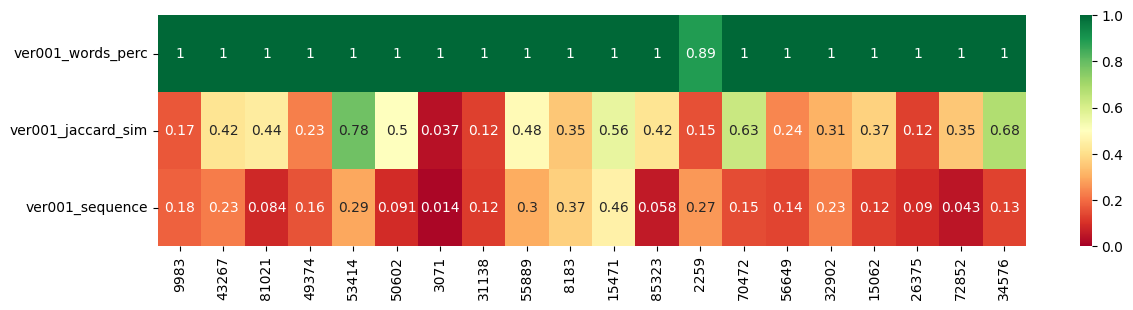

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

transposed_corpus = corpus.iloc[:, -3:].T
plt.figure(figsize=(14, 3))
sns.heatmap(transposed_corpus, cmap='RdYlGn', vmin=0, vmax=1, annot=True)

# Show the plot
plt.show()

As we have seen before, the model excels at indentifying the correct answer but its way too verbose. Percentage of desired words is highg but similarity of the strings is low overall.

## Version 002

This new version has a better system prompt and defined hyperparameters

In [74]:
VERSION = "ver002"

config = {
    "temperature": 0,
    "max_tokens": 16,
    "top_p": 1,
}

corpus_v2 = corpus.copy()

In [75]:
corpus_v2[f'{VERSION}_llm_answer'] = corpus_v2.apply(lambda row:
  openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[
      {"role": "system", "content": 
        f"""
        You are an API given the following context: /n
        ###
        {row['context']}
        ###
        Will reply as concisely as possible to the user question.
        """
      },
      {"role": "user", "content": row ['question']},
      ],
    temperature=config["temperature"],
    max_tokens=config["max_tokens"],
    top_p=config["top_p"],
  ).get("choices")[0]["message"]["content"],
  axis = 1
  )

In [77]:
corpus_v2[f"{VERSION}_words_perc"] = corpus_v2.apply(lambda row: evals.percentage_of_words(row[f'{VERSION}_llm_answer'], row['answers']), axis=1)
corpus_v2[f"{VERSION}_jaccard_sim"] = corpus_v2.apply(lambda row: jaccard_similarity(row[f'{VERSION}_llm_answer'], row['answers']), axis=1)
corpus_v2[f"{VERSION}_sequence"] = corpus_v2.apply(lambda row: sequence_matcher(row[f'{VERSION}_llm_answer'], row['answers']), axis=1)

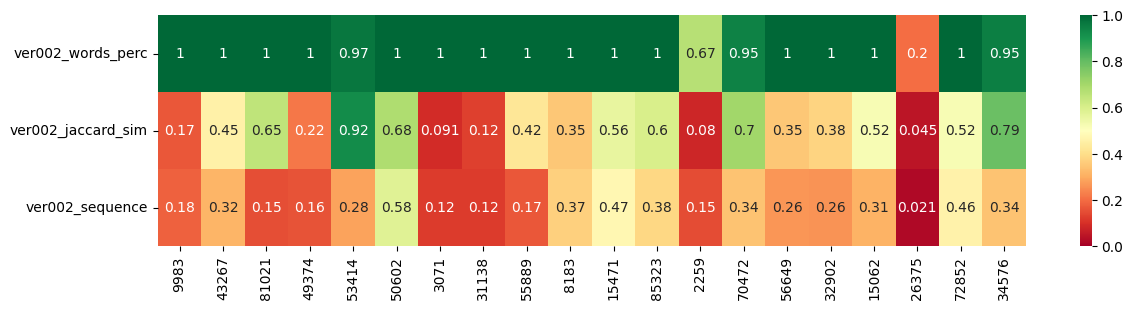

In [78]:
transposed_corpus_v2 = corpus_v2.iloc[:, -3:].T
plt.figure(figsize=(14, 3))
sns.heatmap(transposed_corpus_v2, cmap='RdYlGn', vmin=0, vmax=1, annot=True)

# Show the plot
plt.show()

Quite poor still, and with even a drop in performance in some of the examples

In [102]:
print(f'To the question: {corpus_v2.iloc[-3]["question"]}')
print(f'with the desired answer: {corpus_v2.iloc[-3]["answers"]}')
print(f'Version 1 answered: {corpus_v2.iloc[-3]["ver001_llm_answer"]}')
print(f'Version 2 answered: {corpus_v2.iloc[-3]["ver002_llm_answer"]}')

To the question: When did Houston begin to regain its dependence on the oil industry?
with the desired answer: 2000s
Version 1 answered: Houston began to regain its dependence on the oil industry in the 2000s, specifically after the increase in oil prices during that time.
Version 2 answered: Houston began to regain its dependence on the oil industry since the increase of oil prices


Hardly any improvement, let's see

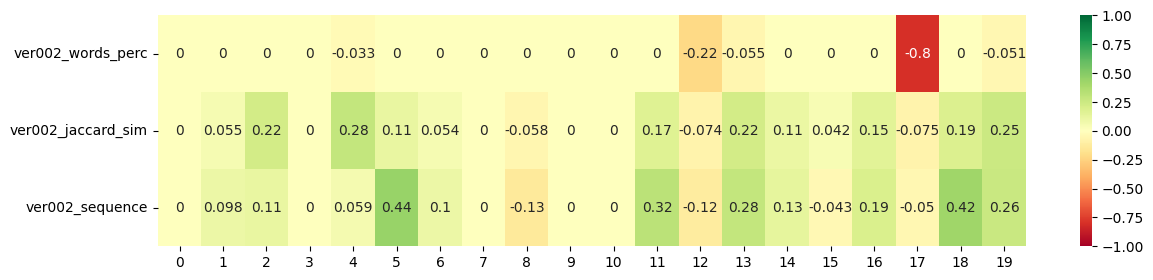

In [80]:
# Select columns with ver001 and ver002
ver001_cols = corpus.columns[-3:]
ver002_cols = corpus_v2.columns[-3:]

# Calculate the difference between ver001 and ver002 columns
diff_df = corpus_v2[ver002_cols].values - corpus_v2[ver001_cols].values

# Create a new DataFrame with the differences
diff_df = pd.DataFrame(diff_df, columns=ver002_cols)

# Plot the heatmap
plt.figure(figsize=(14, 3))
sns.heatmap(diff_df.T, cmap='RdYlGn', vmin=-1, vmax=1, annot=True)

# Show the plot
plt.show()

let's try to refine our prompt

## Version 3
Same model and parameters but with a reworded last sentence in the prompt

In [81]:
VERSION = "ver003"

config = {
    "temperature": 0,
    "max_tokens": 16,
    "top_p": 1,
}

corpus_v3 = corpus.copy()

In [82]:
corpus_v3[f'{VERSION}_llm_answer'] = corpus_v3.apply(lambda row:
  openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[
      {"role": "system", "content": 
        f"""
        You are an API given the following context: /n
        ###
        {row['context']}
        ###
        Will reply concisely, using as few words as possible, to the user question.
        """
      },
      {"role": "user", "content": row ['question']},
      ],
    temperature=config["temperature"],
    max_tokens=config["max_tokens"],
    top_p=config["top_p"],
  ).get("choices")[0]["message"]["content"],
  axis = 1
  )

In [84]:
corpus_v3[f"{VERSION}_words_perc"] = corpus_v3.apply(lambda row: evals.percentage_of_words(row[f'{VERSION}_llm_answer'], row['answers']), axis=1)
corpus_v3[f"{VERSION}_jaccard_sim"] = corpus_v3.apply(lambda row: jaccard_similarity(row[f'{VERSION}_llm_answer'], row['answers']), axis=1)
corpus_v3[f"{VERSION}_sequence"] = corpus_v3.apply(lambda row: sequence_matcher(row[f'{VERSION}_llm_answer'], row['answers']), axis=1)

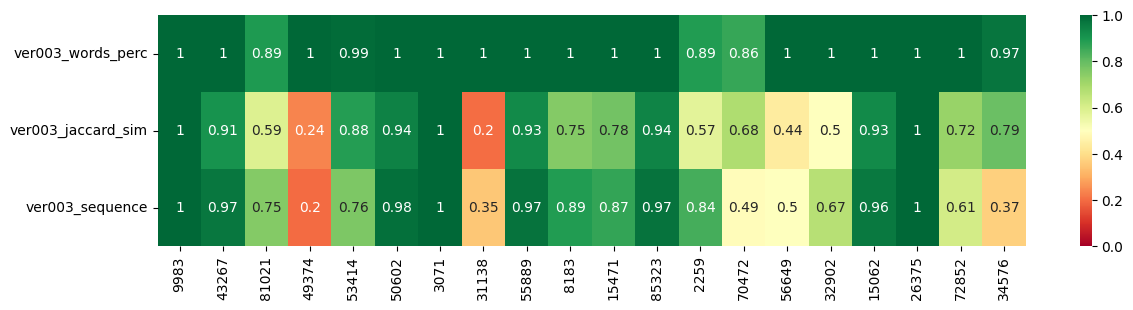

In [85]:
transposed_corpus_v3 = corpus_v3.iloc[:, -3:].T
plt.figure(figsize=(14, 3))
sns.heatmap(transposed_corpus_v3, cmap='RdYlGn', vmin=0, vmax=1, annot=True)

# Show the plot
plt.show()

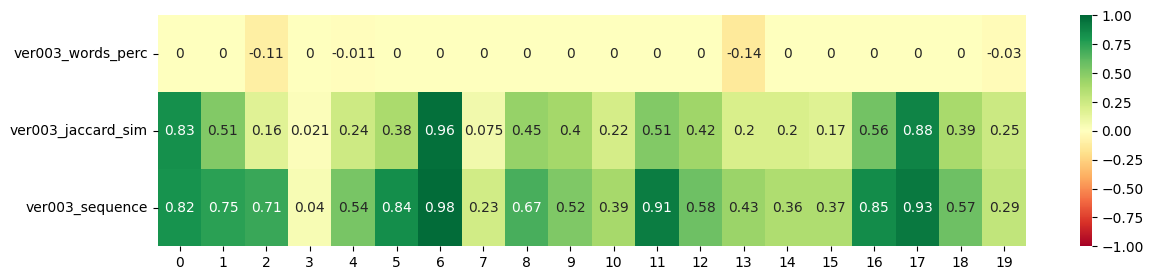

In [86]:
# Select columns with ver001 and ver002
ver001_cols = corpus.columns[-3:]
ver003_cols = corpus_v3.columns[-3:]

# Calculate the difference between ver001 and ver002 columns
diff_df = corpus_v3[ver003_cols].values - corpus_v3[ver001_cols].values

# Create a new DataFrame with the differences
diff_df = pd.DataFrame(diff_df, columns=ver003_cols)

# Plot the heatmap
plt.figure(figsize=(14, 3))
sns.heatmap(diff_df.T, cmap='RdYlGn', vmin=-1, vmax=1, annot=True)

# Show the plot
plt.show()

In [ ]:
print(f'To the question: {corpus_v3.iloc[0]["question"]}')
print(f'with the desired answer: {corpus_v3.iloc[0]["answers"]}')
print(f'Version 1 answered: {corpus_v3.iloc[0]["ver001_llm_answer"]}')
print(f'Version 3 answered: {corpus_v3.iloc[0]["ver003_llm_answer"]}')

To the question: What year was the Banská Akadémia founded?
with the desired answer: 1735
Version 1 answered: The Banská Akadémia in Banská Štiavnica, Slovakia was founded in 1735.
Version 3 answered: 1735
